# CMA-MEGA v2 vs v3 Comparison

This notebook compares CMA-MEGA v2 and v3 implementations across 5 different random seeds to evaluate performance consistency and improvements.

In [1]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import flax
import chex
import jumanji
import qdax

from qdax.core.map_elites import MAPElites
from qdax.core.emitters.cma_mega_emitter_v2 import CMAMEGAEmitter as CMAMEGAEmitterV2
from qdax.core.emitters.cma_mega_emitter_v3 import CMAMEGAEmitter as CMAMEGAEmitterV3
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
from qdax.utils.plotting import plot_map_elites_results

from typing import Dict

print("Libraries imported successfully!")

2025-11-23 19:57:28.067910: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Libraries imported successfully!


/home/tin/anaconda3/envs/mix-me/lib/python3.10/site-packages/brax/v1/jumpy.py:34: DeprecationWarning: brax.v1 is deprecated and will be removed in a future release.
  warnings.warn(
/home/tin/anaconda3/envs/mix-me/lib/python3.10/site-packages/brax/v1/__init__.py:26: DeprecationWarning: brax.v1 is deprecated and will be removed in a future release.
  warnings.warn(


## Set the hyperparameters

Most hyperparameters are similar to those introduced in [Differentiable Quality Diversity paper](https://arxiv.org/pdf/2106.03894.pdf).

In [ ]:
#@title QD Training Definitions Fields
#@markdown ---
num_iterations = 20_000 #@param {type:"integer"}
num_dimensions = 100 #@param {type:"integer"}
num_centroids = 10_000 #@param {type:"integer"}
minval = -5.12 #@param {type:"number"}
maxval = 5.12 #@param {type:"number"}
batch_size = 36 #@param {type:"integer"}
learning_rate = 1 #@param {type:"number"}
es_noise = 0.01
sigma_g = 3.16 #@param {type:"number"} # square root of 10, the value given in the paper
mirror_sampling = False
exact_gradient = False
num_seeds = 3 #@param {type:"integer"}
#@markdown ---

print(f"Configuration:")
print(f"  Iterations: {num_iterations}")
print(f"  Dimensions: {num_dimensions}")
print(f"  Centroids: {num_centroids}")
print(f"  Batch size: {batch_size}")
print(f"  Seeds: {num_seeds}")

Configuration:
  Iterations: 20000
  Dimensions: 100
  Centroids: 10000
  Batch size: 36
  Seeds: 5


## Define the scoring function: rastrigin

As we are in the Differentiable QD setting, the scoring function does not only retrieve the fitness and descriptors, but also the gradients.

In [3]:
def rastrigin_scoring(x: jnp.ndarray):
    return -(10 * x.shape[-1] + jnp.sum((x+minval*0.4)**2 - 10 * jnp.cos(2 * jnp.pi * (x+minval*0.4))))

def clip(x: jnp.ndarray):
    return x*(x<=maxval)*(x>=+minval) + maxval/x*((x>maxval)+(x<+minval))

def _rastrigin_descriptor_1(x: jnp.ndarray):
    return jnp.mean(clip(x[:x.shape[-1]//2]))

def _rastrigin_descriptor_2(x: jnp.ndarray):
    return jnp.mean(clip(x[x.shape[-1]//2:]))

def rastrigin_descriptors(x: jnp.ndarray):
    return jnp.array([_rastrigin_descriptor_1(x), _rastrigin_descriptor_2(x)])

rastrigin_grad_scores = jax.grad(rastrigin_scoring)

In [4]:
def scoring_function(x):
    scores, descriptors = rastrigin_scoring(x), rastrigin_descriptors(x)
    gradients = jnp.array([rastrigin_grad_scores(x), jax.grad(_rastrigin_descriptor_1)(x), jax.grad(_rastrigin_descriptor_2)(x)]).T
    gradients = jnp.nan_to_num(gradients)

    # Compute normalized gradients
    norm_gradients = jax.tree_util.tree_map(
        lambda x: jnp.linalg.norm(x, axis=1, keepdims=True),
        gradients,
    )
    grads = jax.tree_util.tree_map(
        lambda x, y: x / y, gradients, norm_gradients
    )
    grads = jnp.nan_to_num(grads)
    extra_scores = {
        'gradients': gradients,
        'normalized_grads': grads
    }

    return scores, descriptors, extra_scores

def scoring_fn(x, random_key):
    fitnesses, descriptors, extra_scores = jax.vmap(scoring_function)(x)
    return fitnesses, descriptors, extra_scores, random_key

## Define the metrics that will be used

In [5]:
worst_objective = rastrigin_scoring(-jnp.ones(num_dimensions) * 5.12)
best_objective = rastrigin_scoring(jnp.ones(num_dimensions) * 5.12 * 0.4)


def metrics_fn(repertoire: MapElitesRepertoire) -> Dict[str, jnp.ndarray]:

    # get metrics
    grid_empty = repertoire.fitnesses == -jnp.inf
    adjusted_fitness = (
        (repertoire.fitnesses - worst_objective) / (best_objective - worst_objective)
    )
    qd_score = jnp.sum(adjusted_fitness, where=~grid_empty) / num_centroids
    coverage = 100 * jnp.mean(1.0 - grid_empty)
    max_fitness = jnp.max(adjusted_fitness)
    return {"qd_score": qd_score, "max_fitness": max_fitness, "coverage": coverage}

## Training function for a single seed

In [6]:
def train_single_seed(seed, emitter_class, version_name):
    """
    Train a single instance of CMA-MEGA with a given seed.
    
    Args:
        seed: Random seed for initialization
        emitter_class: Either CMAMEGAEmitterV2 or CMAMEGAEmitterV3
        version_name: String name for logging ("v2" or "v3")
    
    Returns:
        metrics: Dictionary of metrics collected during training
    """
    print(f"Training {version_name} with seed {seed}...")
    
    random_key = jax.random.PRNGKey(seed)
    
    # Initialize population
    initial_population = jax.random.uniform(random_key, shape=(batch_size, num_dimensions)) * 0.

    # Compute centroids
    centroids, random_key = compute_cvt_centroids(
        num_descriptors=2, 
        num_init_cvt_samples=25_000, 
        num_centroids=num_centroids, 
        minval=minval, 
        maxval=maxval,
        random_key=random_key,
    )

    # Create emitter
    emitter = emitter_class(
        scoring_function=scoring_fn,
        batch_size=batch_size,
        learning_rate=learning_rate,
        num_descriptors=2,
        centroids=centroids,
        sigma_g=sigma_g,
        exact_gradient=exact_gradient,
        es_batch_size=batch_size,
        es_noise=es_noise,
        mirrored_sampling=mirror_sampling
    )

    # Create MAP-Elites instance
    map_elites = MAPElites(
        scoring_function=scoring_fn,
        emitter=emitter,
        metrics_function=metrics_fn
    )
    
    # Initialize
    repertoire, emitter_state, random_key = map_elites.init(initial_population, centroids, random_key)
    
    # Train
    (repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
        map_elites.scan_update,
        (repertoire, emitter_state, random_key),
        (),
        length=num_iterations,
    )
    
    print(f"  {version_name} seed {seed} - Final QD Score: {metrics['qd_score'][-1]:.4f}, Coverage: {metrics['coverage'][-1]:.2f}%")
    
    return metrics, repertoire

## Run experiments for both versions across all seeds

In [7]:
%%time

# Storage for results
results_v2 = []
results_v3 = []
repertoires_v2 = []
repertoires_v3 = []

seeds = [i for i in range(num_seeds)]

# Train v2
print("="*60)
print("Training CMA-MEGA v2")
print("="*60)
for seed in seeds:
    metrics, repertoire = train_single_seed(seed, CMAMEGAEmitterV2, "v2")
    results_v2.append(metrics)
    repertoires_v2.append(repertoire)

print("\n" + "="*60)
print("Training CMA-MEGA v3")
print("="*60)
# Train v3
for seed in seeds:
    metrics, repertoire = train_single_seed(seed, CMAMEGAEmitterV3, "v3")
    results_v3.append(metrics)
    repertoires_v3.append(repertoire)

print("\n" + "="*60)
print("Training completed!")
print("="*60)

Training CMA-MEGA v2
Training v2 with seed 0...


/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=4/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=6/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN

/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=4/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=6/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN

/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=4/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=6/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN

/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=4/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=6/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN

/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=4/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=6/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN

/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=4/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=6/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN

/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=4/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=6/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN

/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=4/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=6/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN

/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=4/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=6/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN

/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=4/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=4/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN CMAES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
coeffs shape Traced<ShapedArray(float32[36,3])>with<DynamicJaxprTrace(level=6/0)>, grads shape (100, 3)
update_grad shape Traced<ShapedArray(float32[36,100])>with<DynamicJaxprTrace(level=6/0)>
IN ES!: cur_step Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=6/0)>
gradient shape at estimate ES (1, 100, 3)
IN

## Process results and compute statistics

In [8]:
# Convert metrics to numpy arrays for easier manipulation
def stack_metrics(results_list):
    """Stack metrics from multiple runs into arrays."""
    stacked = {}
    metric_names = results_list[0].keys()
    for metric in metric_names:
        stacked[metric] = np.stack([np.array(r[metric]) for r in results_list])
    return stacked

v2_stacked = stack_metrics(results_v2)
v3_stacked = stack_metrics(results_v3)

# Compute mean and std
v2_mean = {k: np.mean(v, axis=0) for k, v in v2_stacked.items()}
v2_std = {k: np.std(v, axis=0) for k, v in v2_stacked.items()}

v3_mean = {k: np.mean(v, axis=0) for k, v in v3_stacked.items()}
v3_std = {k: np.std(v, axis=0) for k, v in v3_stacked.items()}

# Create x-axis
env_steps = np.arange(num_iterations) * batch_size

print("Statistics computed successfully!")

Statistics computed successfully!


## Visualize comparison results

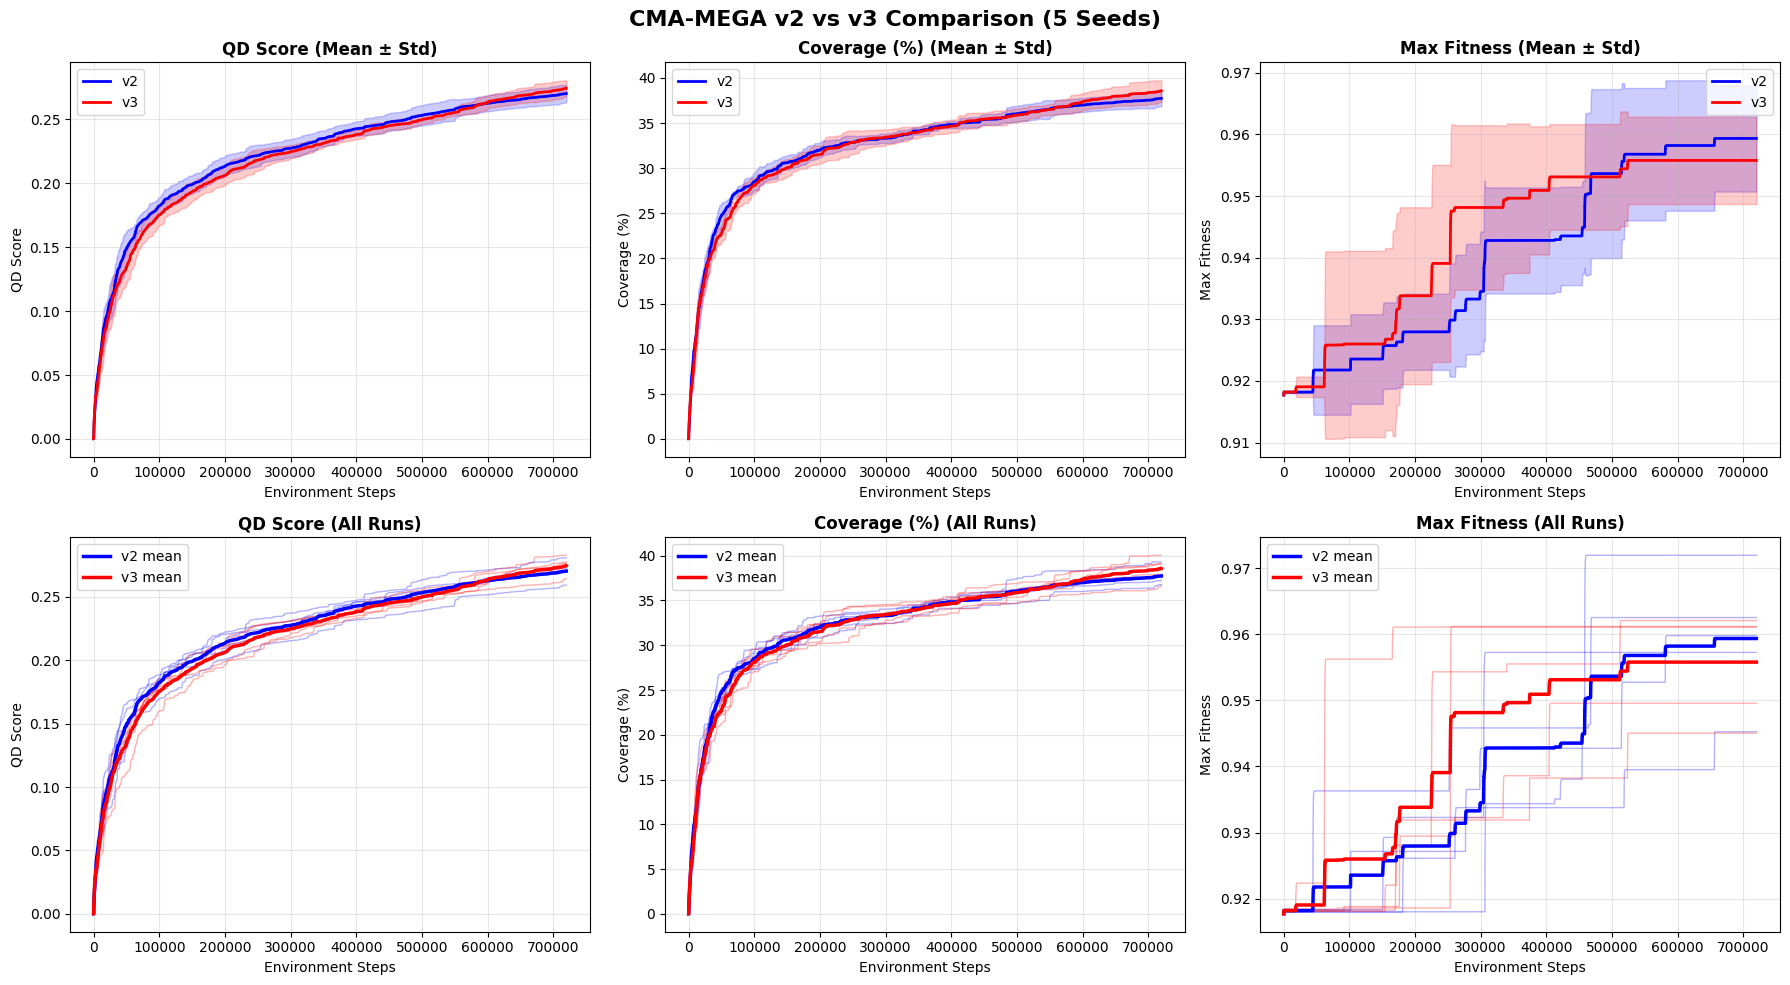

In [9]:
%matplotlib inline

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('CMA-MEGA v2 vs v3 Comparison (5 Seeds)', fontsize=16, fontweight='bold')

metrics_to_plot = ['qd_score', 'coverage', 'max_fitness']
titles = ['QD Score', 'Coverage (%)', 'Max Fitness']

# Plot mean with std deviation
for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[0, idx]
    
    # v2
    ax.plot(env_steps, v2_mean[metric], label='v2', color='blue', linewidth=2)
    ax.fill_between(env_steps, 
                     v2_mean[metric] - v2_std[metric], 
                     v2_mean[metric] + v2_std[metric], 
                     alpha=0.2, color='blue')
    
    # v3
    ax.plot(env_steps, v3_mean[metric], label='v3', color='red', linewidth=2)
    ax.fill_between(env_steps, 
                     v3_mean[metric] - v3_std[metric], 
                     v3_mean[metric] + v3_std[metric], 
                     alpha=0.2, color='red')
    
    ax.set_xlabel('Environment Steps', fontsize=10)
    ax.set_ylabel(title, fontsize=10)
    ax.set_title(f'{title} (Mean ± Std)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Plot all individual runs
for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[1, idx]
    
    # v2 individual runs
    for i, result in enumerate(results_v2):
        ax.plot(env_steps, result[metric], color='blue', alpha=0.3, linewidth=1)
    
    # v3 individual runs
    for i, result in enumerate(results_v3):
        ax.plot(env_steps, result[metric], color='red', alpha=0.3, linewidth=1)
    
    # Plot means on top
    ax.plot(env_steps, v2_mean[metric], label='v2 mean', color='blue', linewidth=2.5)
    ax.plot(env_steps, v3_mean[metric], label='v3 mean', color='red', linewidth=2.5)
    
    ax.set_xlabel('Environment Steps', fontsize=10)
    ax.set_ylabel(title, fontsize=10)
    ax.set_title(f'{title} (All Runs)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Print final statistics

In [10]:
print("="*60)
print("FINAL RESULTS (Mean ± Std over 5 seeds)")
print("="*60)

for metric in metrics_to_plot:
    v2_final_mean = v2_mean[metric][-1]
    v2_final_std = v2_std[metric][-1]
    v3_final_mean = v3_mean[metric][-1]
    v3_final_std = v3_std[metric][-1]
    
    print(f"\n{metric.upper()}:")
    print(f"  v2: {v2_final_mean:.4f} ± {v2_final_std:.4f}")
    print(f"  v3: {v3_final_mean:.4f} ± {v3_final_std:.4f}")
    
    diff = v3_final_mean - v2_final_mean
    pct_change = (diff / abs(v2_final_mean)) * 100 if v2_final_mean != 0 else 0
    print(f"  Difference: {diff:+.4f} ({pct_change:+.2f}%)")

print("\n" + "="*60)

FINAL RESULTS (Mean ± Std over 5 seeds)

QD_SCORE:
  v2: 0.2703 ± 0.0069
  v3: 0.2744 ± 0.0062
  Difference: +0.0041 (+1.51%)

COVERAGE:
  v2: 37.7420 ± 0.8535
  v3: 38.5600 ± 1.1674
  Difference: +0.8180 (+2.17%)

MAX_FITNESS:
  v2: 0.9593 ± 0.0086
  v3: 0.9558 ± 0.0071
  Difference: -0.0036 (-0.37%)



## Visualize final repertoires

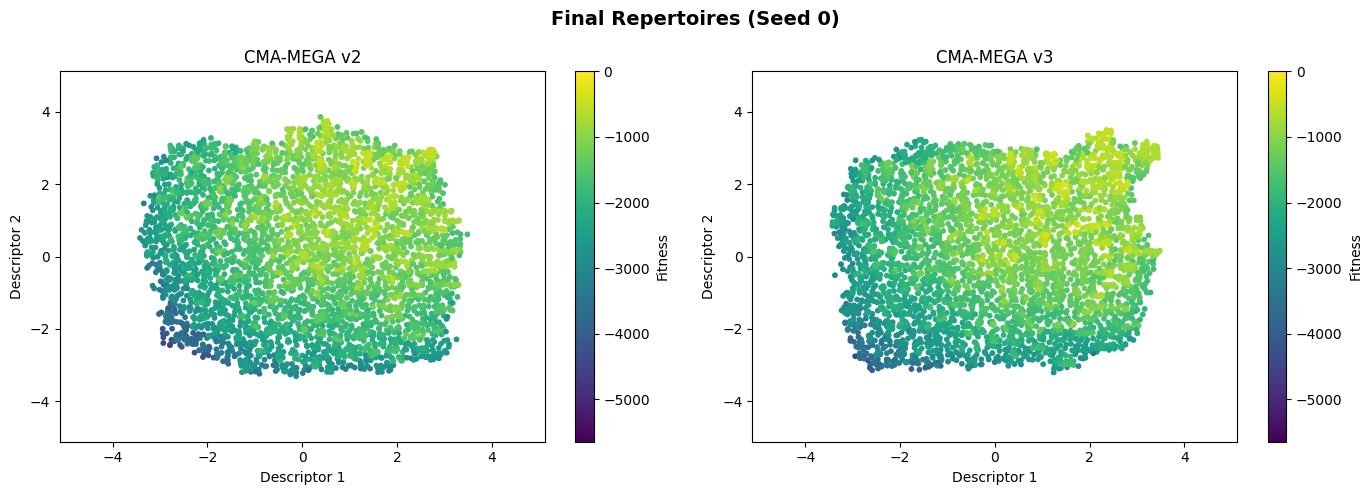

In [11]:
# Plot first seed's final repertoire for both versions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Final Repertoires (Seed 0)', fontsize=14, fontweight='bold')

# v2 repertoire
ax = axes[0]
im = ax.scatter(repertoires_v2[0].descriptors[:, 0], 
                repertoires_v2[0].descriptors[:, 1],
                c=repertoires_v2[0].fitnesses,
                cmap='viridis',
                s=10,
                vmin=worst_objective,
                vmax=best_objective)
ax.set_xlabel('Descriptor 1')
ax.set_ylabel('Descriptor 2')
ax.set_title('CMA-MEGA v2')
ax.set_xlim(minval, maxval)
ax.set_ylim(minval, maxval)
plt.colorbar(im, ax=ax, label='Fitness')

# v3 repertoire
ax = axes[1]
im = ax.scatter(repertoires_v3[0].descriptors[:, 0], 
                repertoires_v3[0].descriptors[:, 1],
                c=repertoires_v3[0].fitnesses,
                cmap='viridis',
                s=10,
                vmin=worst_objective,
                vmax=best_objective)
ax.set_xlabel('Descriptor 1')
ax.set_ylabel('Descriptor 2')
ax.set_title('CMA-MEGA v3')
ax.set_xlim(minval, maxval)
ax.set_ylim(minval, maxval)
plt.colorbar(im, ax=ax, label='Fitness')

plt.tight_layout()
plt.show()